# Retrieval

Retrieval is the centerpiece of our retrieval augmented generation (RAG) flow. 

Let's get our vectorDB from before.

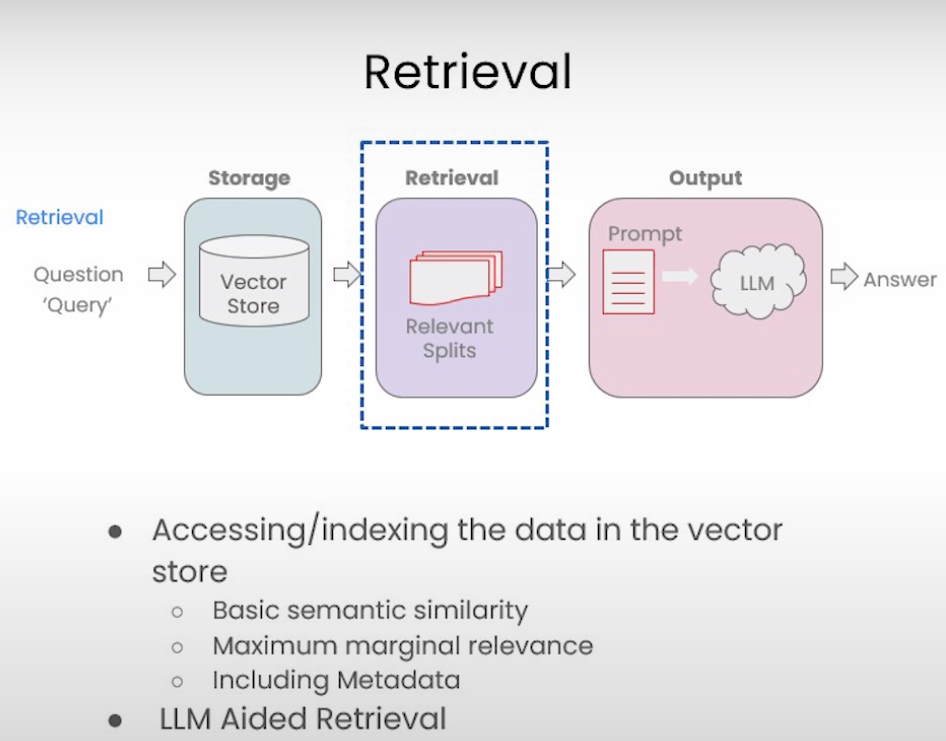

## Vectorstore retrieval


In [11]:
import os
import sys
sys.path.append('../..')

from langchain_openai import AzureChatOpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

api_key  = os.environ['OPENAI_API_KEY']
deployment_embedding= os.getenv("AZURE_DEPLOYMENT_EMBEDDING")
deployment_llm= os.getenv("AZURE_DEPLOYMENT_GPT35B")

In [ ]:
#!pip install lark

### Similarity Search

In [13]:
from langchain.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings
persist_directory = 'docs/chroma/'

In [14]:
embedding = AzureOpenAIEmbeddings()
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [15]:
print(vectordb._collection.count())

3244


In [9]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [10]:
smalldb = Chroma.from_texts(texts, embedding=embedding)

In [11]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [12]:
smalldb.similarity_search(question, k=2)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).')]

In [13]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.')]

### Addressing Diversity: Maximum marginal relevance

Last class we introduced one problem: how to enforce diversity in the search results.
 
`Maximum marginal relevance` strives to achieve both relevance to the query *and diversity* among the results.

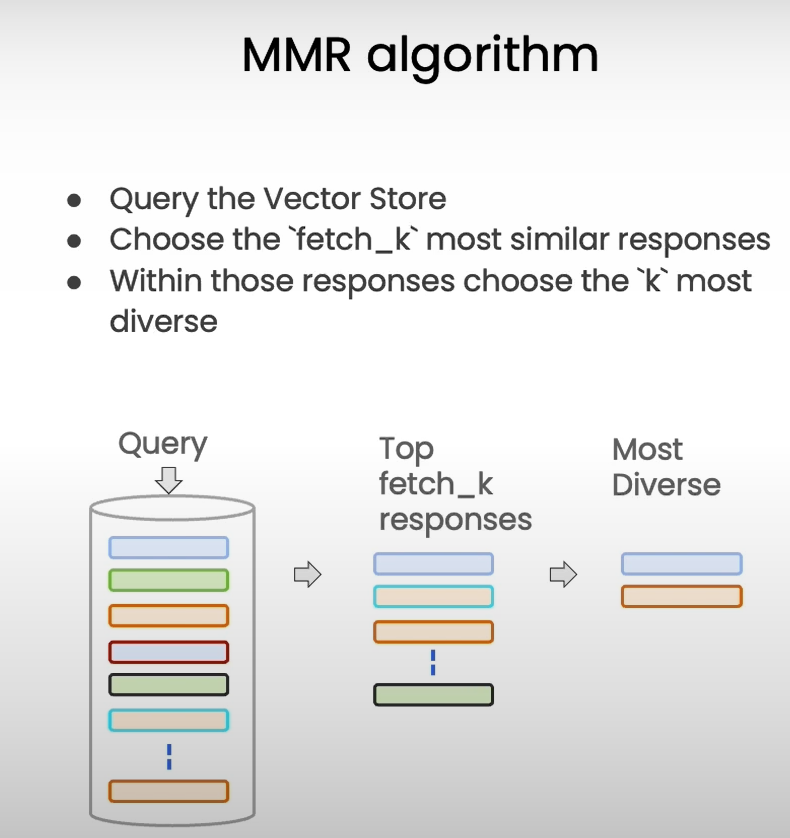

In [14]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

In [15]:
docs_ss[0].page_content[:100]

'MATHEMATICS  FOR \nMACHINE LEAR NING\nMarc Peter Deisenroth\nA. Aldo Faisal\nCheng Soon On g\nMATHEMATICS'

In [16]:
docs_ss[1].page_content[:100]

'MATHEMATICS  FOR \nMACHINE LEAR NING\nMarc Peter Deisenroth\nA. Aldo Faisal\nCheng Soon On g\nMATHEMATICS'

Note the difference in results with `MMR`.

In [17]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)

In [18]:
docs_mmr[0].page_content[:100]

'MATHEMATICS  FOR \nMACHINE LEAR NING\nMarc Peter Deisenroth\nA. Aldo Faisal\nCheng Soon On g\nMATHEMATICS'

In [19]:
docs_mmr[1].page_content[:100]

'398 References\nEaton, Morris L. 2007. Multivariate Statistics: A Vector Space Approach . Institute o'

### Addressing Specificity: working with metadata

In last lecture, we showed that a question about the third lecture can include results from other lectures as well.

To address this, many vectorstores support operations on `metadata`.

`metadata` provides context for each embedded chunk.

In [20]:
question = "what did they say about regression in the third lecture?"

In [24]:
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":'data\\mml-book.pdf'}
)

In [25]:
for d in docs:
    print(d.metadata)

{'page': 295, 'source': 'data\\mml-book.pdf'}
{'page': 295, 'source': 'data\\mml-book.pdf'}
{'page': 295, 'source': 'data\\mml-book.pdf'}


### Addressing Specificity: working with metadata using self-query retriever

But we have an interesting challenge: we often want to infer the metadata from the query itself.

To address this, we can use `SelfQueryRetriever`, which uses an LLM to extract:
 
1. The `query` string to use for vector search
2. A metadata filter to pass in as well

Most vector databases support metadata filters, so this doesn't require any new databases or indexes.

In [16]:
from langchain_openai import AzureChatOpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [28]:
{'source': 'data\\mml-book.pdf', 'page': 0}
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be in 'data/mml-book.pdf'",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

In [29]:
pip install lark -q

Note: you may need to restart the kernel to use updated packages.


In [30]:
llm = AzureChatOpenAI(model_name=deployment_llm, temperature=0)

In [31]:
llm.invoke("hola")

AIMessage(content='¡Hola! ¿En qué puedo ayudarte hoy?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 9, 'total_tokens': 20}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-f9980d82-2d4b-4a6f-9c4c-e49a8f170fd8-0')

In [32]:
document_content_description = "Lecture notes"

retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [33]:
question = "what did they say about regression in the third lecture?"

**You will receive a warning** about predict_and_parse being deprecated the first time you executing the next line. This can be safely ignored.

In [34]:
docs = retriever.get_relevant_documents(question)

OutputParserException: Parsing text
```json
{
    "query": "regression",
    "filter": "eq(\"source\", \"data/mml-book.pdf\") and eq(\"page\", 3)"
}
```
 raised following error:
Unexpected token Token('CNAME', 'and') at line 1, column 35.
Expected one of: 
	* $END
Previous tokens: [Token('RPAR', ')')]


In [27]:
for d in docs:
    print(d.metadata)

NameError: name 'docs' is not defined

### Additional tricks: compression

Another approach for improving the quality of retrieved docs is compression.

Information most relevant to a query may be buried in a document with a lot of irrelevant text. 

Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. 

In [35]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [36]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [37]:
# Wrap our vectorstore

compressor = LLMChainExtractor.from_llm(llm)

In [38]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [42]:
question = "what did they say about linear independency?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

c:\repo_proyectos\poc-rag-lanchain\.venv\Lib\site-packages\langchain\chains\llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\repo_proyectos\poc-rag-lanchain\.venv\Lib\site-packages\langchain\chains\llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\repo_proyectos\poc-rag-lanchain\.venv\Lib\site-packages\langchain\chains\llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\repo_proyectos\poc-rag-lanchain\.venv\Lib\site-packages\langchain\chains\llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

Linear independence is one of the most important concepts in linear algebra. Intuitively, a set of linearly independent vectors consists of vectors that have no redundancy, i.e., if we remove any of those vectors from the set, we will lose something.
----------------------------------------------------------------------------------------------------
Document 2:

Linear independence is one of the most important concepts in linear algebra. Intuitively, a set of linearly independent vectors consists of vectors that have no redundancy, i.e., if we remove any of those vectors from the set, we will lose something.
----------------------------------------------------------------------------------------------------
Document 3:

Linear independence is one of the most important concepts in linear algebra. Intuitively, a set of linearly independent vectors consists of vectors that have no redundancy, i.e., if we remove any of those vectors from the set, we will lose something.
------

In [43]:
compressed_docs

[Document(page_content='Linear independence is one of the most important concepts in linear algebra. Intuitively, a set of linearly independent vectors consists of vectors that have no redundancy, i.e., if we remove any of those vectors from the set, we will lose something.', metadata={'page': 45, 'source': 'data\\mml-book.pdf'}),
 Document(page_content='Linear independence is one of the most important concepts in linear algebra. Intuitively, a set of linearly independent vectors consists of vectors that have no redundancy, i.e., if we remove any of those vectors from the set, we will lose something.', metadata={'page': 45, 'source': 'data\\mml-book.pdf'}),
 Document(page_content='Linear independence is one of the most important concepts in linear algebra. Intuitively, a set of linearly independent vectors consists of vectors that have no redundancy, i.e., if we remove any of those vectors from the set, we will lose something.', metadata={'page': 45, 'source': 'data\\mml-book.pdf'}),
 

## Combining various techniques

In [44]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [45]:
question = "what did they say about linear independency?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

c:\repo_proyectos\poc-rag-lanchain\.venv\Lib\site-packages\langchain\chains\llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\repo_proyectos\poc-rag-lanchain\.venv\Lib\site-packages\langchain\chains\llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\repo_proyectos\poc-rag-lanchain\.venv\Lib\site-packages\langchain\chains\llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
c:\repo_proyectos\poc-rag-lanchain\.venv\Lib\site-packages\langchain\chains\llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

Linear independence is one of the most important concepts in linear algebra. Intuitively, a set of linearly independent vectors consists of vectors that have no redundancy, i.e., if we remove any of those vectors from the set, we will lose something.
----------------------------------------------------------------------------------------------------
Document 2:

Consider a vector space Vwithklinearly independent vectors
b1,...,bkandmlinear combinations
x1=k∑
i=1λi1bi,
...
xm=k∑
i=1λimbi.(2.70)

We want to test whether x1,...,xmare linearly independent. For this
purpose, we follow the general approach of testing when∑m
j=1ψjxj=0.

This means that{x1,...,xm}are linearly independent if and only if the
column vectors{λ1,...,λm}are linearly independent.

In a vector space V,mlinear combinations of kvectorsx1,...,xk
are linearly dependent if m>k .

Are the vectors x1,...,x4∈Rnlinearly independent? To answer this
question, we investigate whether the column vectors



1

## Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [46]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# Load PDF
loader = PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)


In [ ]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [ ]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

In [ ]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]